In [3]:
!pip install sentence-transformers==2.2.2
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab import drive
import re
from itertools import combinations, islice
import numpy as np
from sentence_transformers import SentenceTransformer, InputExample, models, losses, util, evaluation
from torch.utils.data import DataLoader
from statistics import mean
from tqdm import tqdm
import random
import torch
import matplotlib.pyplot as plt
import doctest
drive.mount('/content/drive')

# Dataset Overview
## The dataset used in this notebook is sourced from Kaggle and contains information about Amazon products. Each product is described by the following attributes:

Title: The name of the product.

Description: A detailed description of the product.

Bullet Points: Key features and highlights of the product.

Product Type ID: An identifier for the type or category of the product.


## However, the dataset requires substantial data cleaning before it can be effectively used for analysis or modeling.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/fulltrain.csv", on_bad_lines='warn')
df.head(10)

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000
5,2152929,HINS Metal Bucket Shape Plant Pot for Indoor &...,"[Simple and elegant, great for displaying indo...",HINS Brings you the most Elegant Looking Pot w...,5725,950.000000
6,413758,Ungifted: My Life and Journey,NaN,NaN,23,598.000000
7,2026580,Delavala Self Adhesive Kitchen Backsplash Wall...,[HIGH QUALITY PVC MATERIAL: The kitchen alumin...,<p><strong>Aluminum Foil Stickers-good kitchen...,6030,984.251967
8,2050239,PUMA Cali Sport Clean Women's Sneakers White L...,[Style Name:-Cali Sport Clean Women's Sneakers...,NaN,3302,393.700000
9,2998633,Hexwell Essential oil for Home Fragrance Oil A...,[100% Pure And Natural Essential Oil Or Fragra...,"Transform your home, workplace or hotel room i...",8201,393.700787


# Data Cleaning Process
### To prepare the dataset for analysis, the following data cleaning steps were performed:

1. Removal of products without descriptions: All products that did not have a description were deleted from the dataset.
2. Selection of product categories: Only product categories with more than 70 products in the dataset were retained.
3. HTML tag removal: descriptions were cleaned using regular expressions (Regex) to remove any HTML tags.

### These steps ensured that the dataset was clean and balanced, making it suitable for further analysis and modeling.

In [7]:
# 1. Removal of products without descriptions
df.dropna(subset = "DESCRIPTION", axis = "index", inplace = True)

In [8]:
#2. Selection of product categories
counts = df["PRODUCT_TYPE_ID"].value_counts().copy()
counts = pd.DataFrame(counts)
counts.reset_index(inplace=True)
counts2 = counts[counts["count"] > 70]
df = df[df["PRODUCT_TYPE_ID"].isin(counts2["PRODUCT_TYPE_ID"])].copy()

In [5]:
#3. HTML tag removal
def remove_html_tags(text):
    """
    removing leftover html tags, leading and trailing whitespaces, as well as double whitespaces.
    args:
        text: text
    return:
        clean_text: cleaned text
    >>> remove_html_tags('<p>Hello</p>')
    'Hello'
    >>> remove_html_tags('Some <b>bold</b> and <i>italic</i> text')
    'Some bold and italic text'
    """
    clean_text = re.sub(r'<[^>]*>', ' ', text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    clean_text = clean_text.strip()

    return clean_text
if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [ ]:
df["DESCRIPTION"] = df["DESCRIPTION"].apply(lambda x: remove_html_tags(x))

# Creating Positive Training Pairs
### For the purpose of training, positive pairs were constructed as follows:

1. Same Category Pairing: Two products from the same category were paired together to form a positive pair.
2. Balanced Sampling: To maintain balance in the training dataset, no more than 10 positive pairs per product category were included.
3.Ensuring Diversity: Random sampling within each category was employed to ensure that the pairs were diverse and representative of the category as a whole.

### This careful selection process helps in preventing category imbalance and ensures that the training data is diverse and representative of the product categories.

In [12]:
class ProductMatcher:
    def __init__(self, dataframe, max_products_per_category=10):
      """
      Initializes the ProductMatcher with a given DataFrame and a maximum number of products per category.

      Args:
        dataframe (pd.DataFrame): The input DataFrame containing product information.
        max_products_per_category (int, optional): The maximum number of products to consider per category. Defaults to 10.

      Attributes:
        dataframe (pd.DataFrame): Stores the provided DataFrame.
        max_products_per_category (int): Stores the limit for the number of products per category.
      """
    
      self.dataframe = dataframe
      # Set a max limit of products to be considered per category to avoid memory issues
      self.max_products_per_category = max_products_per_category

    def filter_and_match_products(self):
      """
      Filters products by category and generates matched pairs of product descriptions.
      Groups the DataFrame by 'PRODUCT_TYPE_ID' and processes each group to create pairs of product descriptions
      within the same category. Limits processing to the first 5000 categories.

      Returns:
        list: A list of matched product description pairs with their category ID.

      Examples:
        >>> data = {
        ...     'PRODUCT_TYPE_ID': [1, 1, 1, 2, 2, 3],
        ...     'PRODUCT_ID': [101, 102, 103, 201, 202, 301],
        ...     'DESCRIPTION': ['Product A1', 'Product A2', 'Product A3', 'Product B1', 'Product B2', 'Product C1']
        ... }
        >>> df = pd.DataFrame(data)
        >>> matcher = ProductMatcher(df, max_products_per_category=2)
        >>> output = matcher.filter_and_match_products()
        >>> expected_output = [
        ...     ['Product A1', 'Product A2', 1],
        ...     ['Product B1', 'Product B2', 2]
        ... ]
        >>> output == expected_output
        True
      """
      
      output_list = []

      # Group by 'PRODUCT_TYPE_ID' and process each group, limited to first 5 categories
      grouped = self.dataframe.groupby('PRODUCT_TYPE_ID')
      for product_type_id, group in islice(grouped, 5000):  # Limit to first 5000 groups
          matched_pairs = self.process_group(group, product_type_id)
          output_list.extend(matched_pairs)

      return output_list

    def process_group(self, group, product_type_id):
      """
      Processes a single group of products to generate unique pairs of descriptions.

      Args:
        group (pd.DataFrame): A DataFrame containing products of a single category.
        product_type_id (int): The ID of the product category being processed.

      Returns:
        list: A list of pairs of product descriptions with their category ID.
        
      Examples:
        >>> data = {
        ...     'PRODUCT_TYPE_ID': [1, 1, 1],
        ...     'PRODUCT_ID': [101, 102, 103],
        ...     'DESCRIPTION': ['Product A1', 'Product A2', 'Product A3']
        ... }
        >>> df = pd.DataFrame(data)
        >>> matcher = ProductMatcher(df, max_products_per_category=2)
        >>> group = df[df['PRODUCT_TYPE_ID'] == 1]
        >>> output = matcher.process_group(group, 1)
        >>> expected_output = [
        ...     ['Product A1', 'Product A2', 1]
        ... ]
        >>> output == expected_output
        True
      """
    
      # Filter to unique 'PRODUCT_ID' within the group
      unique_products = group.drop_duplicates(subset=['PRODUCT_ID']).head(self.max_products_per_category)

      # Precompute descriptions to avoid accessing DataFrame in loop
      descriptions = unique_products['DESCRIPTION'].tolist()

      # Generate and return all unique pairs within this group, respecting the limit
      return [
          [descriptions[i], descriptions[j], product_type_id]
          for i, j in combinations(range(len(descriptions)), 2)
      ]

if __name__ == "__main__":
    import doctest
    doctest.testmod()
    
matcher = ProductMatcher(df, max_products_per_category=10)
output = matcher.filter_and_match_products()
output_df = pd.DataFrame(output, columns=['Description1', 'Description2', 'Category'])
output_df['Category1'] = output_df['Category']

# Creating Negative Training Pairs
### To generate negative training pairs, the following procedure was implemented:

- Random Selection: Two products from different categories were randomly selected to form a negative pair.
- Category Check: It was ensured that the selected products did not belong to the same category to maintain the integrity of negative pairing.
- Balancing with Positive Pairs: The number of negative pairs was balanced with the positive pairs to avoid any bias in the training dataset.

### This method of generating negative pairs ensures a clear distinction between pairs of the same category and pairs of different categories, which is crucial for effective model training.

In [17]:

num_pairs = len(output_df)

# Create random product pairs
pairs_indices = np.random.choice(df.index, (num_pairs, 2))

# Creating new dataframe with the generated product pairs
df_pairs = pd.DataFrame({
    'Description1': df.loc[pairs_indices[:, 0], 'DESCRIPTION'].values,
    'Description2': df.loc[pairs_indices[:, 1], 'DESCRIPTION'].values,
    'Category': df.loc[pairs_indices[:, 0], 'PRODUCT_TYPE_ID'].values,
    'Category1': df.loc[pairs_indices[:, 1], 'PRODUCT_TYPE_ID'].values
})

df_pairs = df_pairs[df_pairs['Category'] != df_pairs['Category1']]


# Training Data Preparation
### The following steps were performed to prepare the training data:

1. Labeling: The positive and negative pairs were labeled accordingly:
  - Positive pairs were labeled with 1.
  - Negative pairs were labeled with 0.
2. Combining Datasets: The labeled positive and negative pairs were combined into a single dataset.
3. Splitting into Training and Test Sets: Approximately 10% of the combined dataset was set aside as test data.
4. Balanced Distribution: Care was taken to ensure an equal distribution of positive and negative pairs in both the training and test datasets to maintain balance.

### These steps ensure that the training and test datasets are well-prepared, balanced, and ready for model development and evaluation.

In [18]:
#Concat both datasets to one training dataset
output_df["Label"] = 1
df_pairs["Label"] = 0
train_data = pd.concat([output_df, df_pairs]).drop_duplicates(subset=['Description1', 'Description2'],keep=False)

In [19]:
#Generate test data for the training
test_data_positive = train_data[train_data['Label'] == 1].head(9000)
test_data_negative = train_data[train_data['Label'] == 0].head(9000)
test_data = pd.concat([test_data_positive,test_data_negative], ignore_index= True)
train_data = pd.concat([train_data, test_data]).drop_duplicates(keep=False)

# Model Training
### The training process involved the following steps:

1. DataLoader preparation: The prepared training data was fed into a DataLoader to facilitate efficient batching and shuffling during training.
2. Model selection: The state-of-the-art SimCSE model from Princeton, based on RoBERTa-Large and pre-trained on sentence similarity tasks, was selected for fine-tuning.
3. Loss selection: The loss function used was based on the difference between the cosine similarity of the product description embeddings and the corresponding labels.
4. Fine-tuning: The model was fine-tuned over 4 epochs using the training data to specialize it in distinguishing product descriptions.

### By following these steps, the model was effectively trained to discern similarities and differences between product descriptions, leveraging its pre-trained capabilities in sentence similarity and further fine-tuning it for this specific task.

In [ ]:
#1. Dataloader Preparation
train_samples = []
train_data['Label'] = train_data['Label'].astype('float')
for i, row in train_data.iterrows():
    inp_example = InputExample(texts=[row["Description1"], row["Description2"]], label=row["Label"])
    train_samples.append(inp_example)
train_dataloader = DataLoader(train_samples, batch_size=64, shuffle=True)
#2. Model Selection
model_name = 'princeton-nlp/sup-simcse-roberta-large'
word_embedding_model = models.Transformer(model_name, max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device = "cuda")

#3. Loss-Selection
train_loss = losses.CosineSimilarityLoss(model=model)

#4. Fine-tuning of the Model
model.fit(
  train_objectives=[(train_dataloader, train_loss)],
  epochs=1,
  show_progress_bar=True,
  evaluation_steps=5
  )
torch.save(model,"/content/drive/MyDrive/NLP/TestSimCSE1Epoch.pt")

model.fit(
  train_objectives=[(train_dataloader, train_loss)],
  epochs=1,
  show_progress_bar=True,
  evaluation_steps=5
  )
torch.save(model,"/content/drive/MyDrive/NLP/TestSimCSE2Epochs.pt")

model.fit(
  train_objectives=[(train_dataloader, train_loss)],
  epochs=1,
  show_progress_bar=True,
  evaluation_steps=5
  )
torch.save(model,"/content/drive/MyDrive/NLP/TestSimCSE3Epochs.pt")

model.fit(
  train_objectives=[(train_dataloader, train_loss)],
  epochs=1,
  show_progress_bar=True,
  evaluation_steps=5
  )
torch.save(model,"/content/drive/MyDrive/NLP/TestSimCSE4Epochs.pt")



# Epoch Evaluation
### During the training process, the model's performance was evaluated after each epoch using the test data. The following steps were taken:

1. Similarity Calculation: For each epoch, the cosine similarities between product description pairs in the test data were calculated.
2. Average Similarity per Label: The average cosine similarity was computed separately for positive pairs (same product category) and negative pairs (different categories).
3. Visualization: The average similarities for each label were plotted in a graph to visualize the differences across epochs.

### The goal was to maximize the difference in cosine similarity between random pairs (negative pairs) and pairs from the same product category (positive pairs). The results indicated that this difference was maximized by the second epoch, after which further training led to overfitting. This optimal point was identified by observing the plateau and subsequent decline in performance metrics.

In [ ]:
import statistics

def run_test(test_data = test_data, model_path = "/content/drive/MyDrive/NLP/TestSimCSE1Epoch.pt"):
  """
  Runs a test on the given test data using a model loaded from the specified path.
    
  Args:
    test_data (pd.DataFrame): The test data containing descriptions and labels.
    model_path (str): The path to the model file.

  Returns:
    list: The average cosine distances for labels 0 and 1.
  """

  liste_0 = []
  liste_1 = []
  model = torch.load(model_path)
    
  # Add a new column 'CosineDistance' to the test data
  test_data['CosineDistance'] = ""
  test_data['CosineDistance'] = test_data['CosineDistance'].astype('object')

  
  for index, row in tqdm(test_data.iterrows()):
    #print(row)
    # Ensure that both descriptions are not NaN
    if row['Description1'] == row['Description1'] and row['Description2'] == row['Description2']:
      # Encode descriptions using the loaded model
      companyemb = model.encode(row['Description1'], convert_to_tensor=True, device='cuda')
      competitoremb = model.encode(row['Description2'], convert_to_tensor=True, device='cuda')
      #test_data.at[index, 'CosineDistance'] = util.cos_sim(companyemb, competitoremb).item()
    
      # Calculate cosine similarity
      cosine_distance = util.cos_sim(companyemb, competitoremb).item()
    
      # Append cosine distance to the respective list based on the label
      if row["Label"] ==1:
        liste_1.append(cosine_distance)
      else:
        liste_0.append(cosine_distance)
    
      # Update the DataFrame with the cosine distance
      test_data.at[index, 'CosineDistance'] = util.cos_sim(companyemb, competitoremb).item()
  # Return the average cosine distances for labels 0 and 1
  return [statistics.mean(liste_0),statistics.mean(liste_1)]


# Initialize an empty DataFrame to store results
df = pd.DataFrame(columns=["Epoch", "AvgLabelZero", "AvgLabelOne"])

# Loop through different epochs to test models saved at various stages
for x in range(1,5):
  model_path = "/content/drive/MyDrive/NLP/TestSimCSE" +str(x) + "Epochs.pt"
  result = run_test(model_path = model_path, test_data = test_data)

  # Create a new row with the results
  new_row = pd.DataFrame({
    "Epoch": [x],
    "AvgLabelZero": [result[0]],
    "AvgLabelOne": [result[1]]
})
  # Append the new row to the results DataFrame
  df = pd.concat([df, new_row], ignore_index=True)

#59,17

20it [00:01, 17.47it/s]
20it [00:01, 18.46it/s]
20it [00:01, 18.42it/s]
20it [00:01, 17.23it/s]


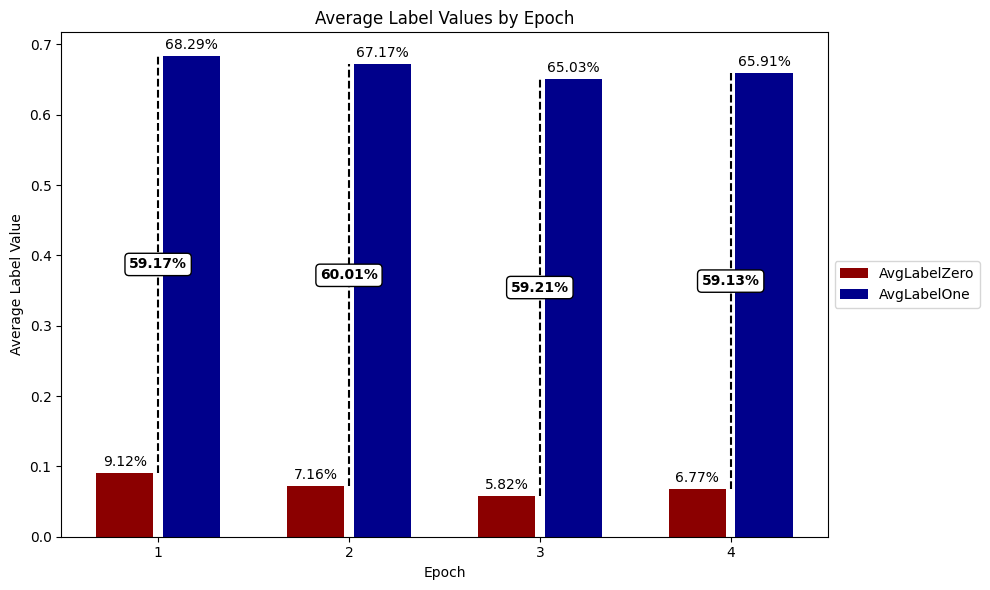

In [ ]:


# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3  # Reduce bar width for a slightly increased spacing
bar_distance = 0.4  # Adjust distance between bar groups
index = np.arange(len(df['Epoch']))

bar1 = ax.bar(index, df['AvgLabelZero'], bar_width, label='AvgLabelZero', color='darkred')
bar2 = ax.bar(index + bar_width + 0.05, df['AvgLabelOne'], bar_width, label='AvgLabelOne', color='darkblue')

# Calculate the difference between AvgLabelZero and AvgLabelOne and display it as a line
for i in range(len(df)):
    avg_label_zero = df['AvgLabelZero'][i]
    avg_label_one = df['AvgLabelOne'][i]
    diff = avg_label_one - avg_label_zero

    # Calculate positions of the bar centers
    x1 = i
    x2 = i + bar_width + 0.05

    # Midpoint position between the bars for the line
    mid_x = (x1 + x2) / 2

    # Annotate the difference as a vertical line with text
    mid_y = (avg_label_zero + avg_label_one) / 2

    # Draw line
    ax.plot([mid_x, mid_x], [avg_label_zero, avg_label_one], color='black', linestyle='--')

    # Label the difference with text on the left side of the line
    ax.text(mid_x, mid_y, f'{diff*100:.2f}%', ha='center', va='center', color='black', fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Set axis labels and title
for i in range(len(df)):
    ax.text(index[i], df['AvgLabelZero'][i] + 0.01, f'{df["AvgLabelZero"][i]*100:.2f}%', ha='center', color='black')
    ax.text(index[i] + bar_width + 0.05, df['AvgLabelOne'][i] + 0.01, f'{df["AvgLabelOne"][i]*100:.2f}%', ha='center', color='black')

ax.set_xlabel('Epoch')
ax.set_ylabel('Average Label Value')
ax.set_title('Average Label Values by Epoch')

# Center the xticks between the bars
ax.set_xticks(index + (bar_width + 0.05) / 2)  
ax.set_xticklabels(df['Epoch'])

# Move legend to the right outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.tight_layout()
plt.show()


# Final Evaluation by Product Category
### To further evaluate the model's performance from the second epoch, we tested its ability to distinguish between product categories. The evaluation focused on categories that appeared at least 5 times in the test data. The following steps were taken:

1. Category Selection: Only product categories with a minimum of 5 occurrences in the test data were selected.
2. Performance Analysis: The model's performance was assessed by identifying the top 5 best and worst performing categories in terms of distinguishing:
  - Categories the model should identify as the same (positive pairs).
  - Categories the model should identify as different (negative pairs).

### The results indicated that the model performed very well overall. For the categories where the model struggled, it was noted that these categories were not meaningfully distinct, highlighting a potential issue with how Amazon selected these categories. This insight underscores the importance of well-defined and curated product categories for optimal model performance.







In [32]:
test_data = pd.read_csv("/content/drive/MyDrive/NLP/Epoch2TestData.csv")

In [4]:
def random_titles(df, type_id):
    """
    Selects a random sample of product titles from the DataFrame based on the specified product type ID.
    
    Args:
        df (pd.DataFrame): The DataFrame containing product information.
        type_id (int): The product type ID to filter the DataFrame.

    Returns:
        pd.Series: A series containing the sampled product titles.

    Examples:
        >>> data = {
        ...     'PRODUCT_TYPE_ID': [1, 1, 2, 2, 3],
        ...     'PRODUCT_ID': [101, 102, 201, 202, 301],
        ...     'TITLE': ['Title A1', 'Title A2', 'Title B1', 'Title B2', 'Title C1']
        ... }
        >>> df = pd.DataFrame(data)
        >>> random.seed(0)  # Set seed for reproducibility in this example
        >>> random_titles(df, 1).tolist()
        ['Title A2']
        >>> random_titles(df, 2).tolist()
        ['Title B2']
        >>> random_titles(df, 3).tolist()
        ['Title C1']
        >>> random_titles(df, 4).tolist()
        Not enough products for TYPE_ID 4. There are only 0 products.
        []
    """
    num_samples = 1
    filtered_df = df[df['PRODUCT_TYPE_ID'] == type_id]
    if len(filtered_df) < num_samples:
        print(f"Not enough products for TYPE_ID {type_id}. There are only {len(filtered_df)} products.")
        num_samples = len(filtered_df)

    samples = filtered_df['TITLE'].sample(n=num_samples, random_state=random.randint(0, 10000))
    return samples

if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [37]:
#top 5 worst and best average_distances per category for similiar category pairs, where there are more than 5 products per category
average_distances = test_data.groupby(['Category', 'Category1']).filter(lambda x: len(x) >= 5).groupby(['Category', 'Category1'])['CosineDistance'].mean().reset_index()
average_distances= average_distances[average_distances['Category'] == average_distances['Category1']]
sorted_distances = average_distances.sort_values(by='CosineDistance')
sorted_distances["ExampleCategory"] = ""
sorted_distances["ExampleCategory1"] = ""
for i, r in sorted_distances.iterrows():
  sorted_distances.at[i, 'ExampleCategory'] = random_titles(df,r["Category"])
  sorted_distances.at[i, 'ExampleCategory1'] = random_titles(df,r["Category1"])
top_5_worst = sorted_distances.head(5)
top_5_best = sorted_distances.tail(5)


In [38]:
top_5_best

,Category,Category1,CosineDistance,ExampleCategory,ExampleCategory1
136,569,569,0.957890,1888120 UGREEN USB 3.0 to SATA Converter Ad...,2076052 Xion XON-SATA1818_Silver 18-Inch SA...
87,348,348,0.963522,1801453 Luxura Sciences Natural Arabica Cof...,98439 Ujjwala Natural And Pure Bamboo Activ...
90,358,358,0.964777,46127 ADS Lip Protectant/Sunscreen Balm Sti...,185842 Chapstick Candy Cane Peppermint (0.1...
129,531,531,0.968976,541048 NIVGROW Heavy Duty Professional Hair...,85006 Kintota Portable eyebrow trimmer for ...
33,133,133,0.989719,780558 Christian Holiness. a Discourse on H...,750823 The Conformity Between Modern and An...


In [39]:
top_5_worst

,Category,Category1,CosineDistance,ExampleCategory,ExampleCategory1
0,0,0,0.087532,452328 WABS Tapioca Root Chips 50gmx4 (Desi...,311819 KitchenDance Colored Disposable Alum...
198,789,789,0.157592,1736956 Kamahiwa Kealii Reichel Collec Name...,"855642 Untitled: Limited Name: TITLE, dtype..."
6,4,4,0.183126,893333 SWIFT GREEN FILTERS SGF-W01 Water Fi...,13985 Sizzix Sidekick Side-Order Set by Tim...
134,555,555,0.217517,"507512 OMG, We're in a Horror Movie Name: T...",1496770 Beware (The Film Detective Restored...
200,829,829,0.275077,"591846 When Breath Escapes Name: TITLE, dty...","601070 The Blackest Curse Name: TITLE, dtyp..."


In [26]:
#top 5 worst and best average_distances per category for dissimiliar category pairs, where there are more than 5 products per category
average_distances = test_data.groupby(['Category', 'Category1']).filter(lambda x: len(x) >= 5).groupby(['Category', 'Category1'])['CosineDistance'].mean().reset_index()
average_distances= average_distances[average_distances['Category'] != average_distances['Category1']]
sorted_distances = average_distances.sort_values(by='CosineDistance',ascending = False)
sorted_distances["ExampleCategory"] = ""
sorted_distances["ExampleCategory1"] = ""
for i, r in sorted_distances.iterrows():

  sorted_distances.at[i, 'ExampleCategory'] = random_titles(df,r["Category"])
  sorted_distances.at[i, 'ExampleCategory1'] = random_titles(df,r["Category1"])


top_5_worst = sorted_distances.head(5)
top_5_best = sorted_distances.tail(5)

,Category,Category1,CosineDistance,ExampleCategory,ExampleCategory1
227,12057,12064,0.584222,"1310927 DJSOK iPhone Xs Case,Pocket Elf Ani...",343758 GODRIC® Cute Cartoon Lovely New Cat ...
242,12556,12064,0.447476,217055 Shockproof Matte Liquid Silicone Cas...,2222501 Oducos Designer Printed Hard Back C...
216,2201,12064,0.362188,1578950 AAHIL Compatible for Samsung Galaxy...,2006199 Pikkme Samsung Galaxy A31 Designer ...
228,12058,12064,0.329867,1805069 COPAAD Samsung Galaxy S10 Wallet Ca...,901329 Pikkme Vivo Y30 / Y50 Designer Print...
240,12064,12556,0.226087,335456 Macaso Printed Designer Mobile Back ...,752606 TORRO Magnetic Cardholder/Wallet – P...


In [28]:
top_5_worst

,Category,Category1,CosineDistance,ExampleCategory,ExampleCategory1
227,12057,12064,0.584222,"1310927 DJSOK iPhone Xs Case,Pocket Elf Ani...",343758 GODRIC® Cute Cartoon Lovely New Cat ...
242,12556,12064,0.447476,217055 Shockproof Matte Liquid Silicone Cas...,2222501 Oducos Designer Printed Hard Back C...
216,2201,12064,0.362188,1578950 AAHIL Compatible for Samsung Galaxy...,2006199 Pikkme Samsung Galaxy A31 Designer ...
228,12058,12064,0.329867,1805069 COPAAD Samsung Galaxy S10 Wallet Ca...,901329 Pikkme Vivo Y30 / Y50 Designer Print...
240,12064,12556,0.226087,335456 Macaso Printed Designer Mobile Back ...,752606 TORRO Magnetic Cardholder/Wallet – P...


In [27]:
top_5_best

,Category,Category1,CosineDistance,ExampleCategory,ExampleCategory1
221,2986,12064,0.001226,1237422 ZOLA Women's Denim A-line Flared Mi...,557347 Apurb Store for Samsung Galaxy Ultra...
217,2211,1634,-0.003533,589419 Prime Retail [Pack of 1] [Anti Rainb...,884535 Hi-Fi Carpets Handwoven Contemporary...
234,12064,2986,-0.006820,1421797 HITFIT Dazzle Hybrid Shockproof Bum...,1088170 COOKI Women's Sexy Tie Dye Short Sl...
222,3081,12064,-0.011275,1128003 Q-rious Women's Regular Fit Trouser...,1375671 YES2GOOD Soft Silicone Coloured But...
230,12064,1396,-0.016505,843819 VediArt Designer Printed Polycarbona...,1621731 FurnishFantasy Ceramic Coffee Mug -...
